In [3]:
import os
import re
import zipfile
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf


# ---------------------------
# 1) Config & Gesture List
# ---------------------------
from pathlib import Path
ROOT = Path.cwd()  # use current working directory instead

ZIP_PATH = ROOT / "combined.zip"
EXTRACT_DIR = ROOT / "combined_extracted"
EXTRACT_DIR.mkdir(exist_ok=True)

GESTURE_LIST = [
    "afternoon","baby","big","born","bye","calendar",
    "child","cloud","come","daily","dance","dark",
    "day","enjoy","go","hello","home","love",
    "my","name","no","rain","sorry","strong",
    "study","thankyou","welcome","wind","yes","you"
]
GESTURE_SET = set(GESTURE_LIST)

In [4]:
# ---------------------------
# 2) Helpers
# ---------------------------
float_pattern = re.compile(r'[-+]?(?:\d+\.?\d*|\.\d+)(?:[eE][-+]?\d+)?')

def read_floats_from_txt(fp: Path):
    txt = fp.read_text(errors='ignore')
    nums = [float(x) for x in float_pattern.findall(txt)]
    return np.array(nums, dtype=np.float64)

def infer_frame_size(nums: np.ndarray):
    if len(nums) >= 120 and len(nums) % 120 == 0:
        return 120
    if len(nums) >= 60 and len(nums) % 60 == 0:
        return 60
    if len(nums) >= 240:
        return 120
    elif len(nums) >= 120:
        return 60
    return None

def reshape_frames(nums: np.ndarray, frame_size: int):
    n_frames = len(nums) // frame_size
    usable = nums[: n_frames * frame_size]
    return usable.reshape(n_frames, frame_size), n_frames

def split_pos_angle(features_frame: np.ndarray):
    D = features_frame.shape[-1]
    if D == 120:
        return slice(0,60), slice(60,120)
    elif D == 60:
        return slice(0,60), None
    else:
        return None, None

def parse_metadata_from_name(stem: str):
    tokens = re.split(r'[\s_\-\.]+', stem.lower())
    label_name = None
    label_id = None
    candidate = None

    for t in tokens:
        if t in GESTURE_SET:
            label_name = t
            break

    for t in tokens:
        if t.isdigit():
            label_id = int(t)
            break

    for t in tokens:
        if re.match(r'^(c\d+|p\d+|subj\d+|person\d+|user\d+)$', t):
            candidate = t
            break
    if candidate is None:
        for t in tokens:
            if not t.isdigit() and t != label_name and t not in {'txt'}:
                candidate = t
                break

    return label_name, label_id, candidate

def label_id_from_name(name: str):
    if name is None:
        return None
    if name in GESTURE_SET:
        return GESTURE_LIST.index(name) + 1
    return None

In [5]:
# ---------------------------
# 3) Unzip & Collect Files
# ---------------------------
if not ZIP_PATH.exists():
    raise FileNotFoundError(f"Could not find {ZIP_PATH}. Place combined.zip next to this script.")

print(f"📦 Extracting {ZIP_PATH.name} ...")
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)

txt_files = sorted([p for p in EXTRACT_DIR.rglob("*.txt")])
print(f"📝 Found {len(txt_files)} txt files.")


📦 Extracting combined.zip ...
📝 Found 2700 txt files.


In [6]:
# ---------------------------
# 4) Build dataset: 240-D per file
# ---------------------------
rows = []
bad_files = []

for fp in txt_files:
    try:
        nums = read_floats_from_txt(fp)
        fs = infer_frame_size(nums)
        if fs is None:
            bad_files.append((fp, f"Not enough numbers ({len(nums)})"))
            continue

        frames, n_frames = reshape_frames(nums, fs)
        pos_slice, ang_slice = split_pos_angle(frames[0])

        feat_means = frames.mean(axis=0)
        feat_stds  = frames.std(axis=0, ddof=0)

        if pos_slice is None:
            bad_files.append((fp, f"Unexpected frame size {frames.shape[1]}"))
            continue

        pos_mean = feat_means[pos_slice]
        pos_std  = feat_stds[pos_slice]

        if ang_slice is not None:
            ang_mean = feat_means[ang_slice]
            ang_std  = feat_stds[ang_slice]
            feats = np.concatenate([pos_mean, pos_std, ang_mean, ang_std], axis=0)  # 240
            col_names = (
                [f"pos_mean_{i+1}" for i in range(60)]
                + [f"pos_std_{i+1}" for i in range(60)]
                + [f"ang_mean_{i+1}" for i in range(60)]
                + [f"ang_std_{i+1}" for i in range(60)]
            )
        else:
            feats = np.concatenate([pos_mean, pos_std], axis=0)  # 120
            col_names = (
                [f"pos_mean_{i+1}" for i in range(60)]
                + [f"pos_std_{i+1}" for i in range(60)]
            )

        stem = fp.stem
        label_name, label_id, candidate = parse_metadata_from_name(stem)
        if label_id is None:
            label_id = label_id_from_name(label_name)

        row = dict(zip(col_names, feats))
        row.update({
            "label_name": label_name,
            "label_id": label_id,
            "candidate": candidate,
            "file": str(fp.relative_to(EXTRACT_DIR)),
            "n_frames": n_frames,
            "frame_size": frames.shape[1],
        })
        rows.append(row)

    except Exception as e:
        bad_files.append((fp, str(e)))

df = pd.DataFrame(rows)
print(f"✅ Parsed {len(df)} files. Skipped {len(bad_files)} problematic files.")
if bad_files:
    print("Examples of skipped files:")
    for fp, msg in bad_files[:5]:
        print(" -", fp.name, "->", msg)

✅ Parsed 2700 files. Skipped 0 problematic files.


In [7]:
# ---------------------------
# 5) Handle Missing Values
# ---------------------------
print("\n🎯 Label coverage (from filenames):")
print(df["label_name"].value_counts(dropna=False).head(40))

feature_cols = [c for c in df.columns if c.startswith(("pos_mean_", "pos_std_", "ang_mean_", "ang_std_"))]
if len(feature_cols) == 0:
    raise RuntimeError("No feature columns detected. Check parsing logic.")

X_raw = df[feature_cols].copy()
y = df["label_name"].copy() if "label_name" in df.columns else None

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X_raw)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# ---------------------------
# 6) Save processed CSV(s)
# ---------------------------
processed = df.drop(columns=feature_cols).copy()
processed_features = pd.DataFrame(X_imputed, columns=feature_cols)
processed_scaled   = pd.DataFrame(X_scaled, columns=[f"scaled::{c}" for c in feature_cols])

full = pd.concat([processed_features, processed, processed_scaled], axis=1)
full_path = ROOT / "processed.csv"
full.to_csv(full_path, index=False)
print(f"💾 Saved processed.csv with shape {full.shape}")

# Create train-final/test-final if labels exist (same as original behaviour)
if y is not None and y.notna().sum() >= 2 and y.nunique() > 1:
    mask_labeled = y.notna()
    X_labeled = processed_features.loc[mask_labeled]
    y_labeled = y.loc[mask_labeled]
    meta_labeled = processed.loc[mask_labeled]

    X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
        X_labeled, y_labeled, meta_labeled, test_size=0.2, random_state=42, stratify=y_labeled
    )

    train_out = pd.concat([X_train.reset_index(drop=True),
                           meta_train.reset_index(drop=True)], axis=1)
    test_out  = pd.concat([X_test.reset_index(drop=True),
                           meta_test.reset_index(drop=True)], axis=1)

    train_out.to_csv(ROOT / "train-final.csv", index=False)
    test_out.to_csv(ROOT / "test-final.csv", index=False)
    print(f"💾 Saved train-final.csv ({train_out.shape}) and test-final.csv ({test_out.shape})")
else:
    print("ℹ️ Not enough labeled data inferred from filenames to make train/test splits.")



🎯 Label coverage (from filenames):
label_name
afternoon    90
baby         90
yes          90
wind         90
welcome      90
thankyou     90
study        90
strong       90
sorry        90
rain         90
no           90
name         90
my           90
love         90
home         90
hello        90
go           90
enjoy        90
day          90
dark         90
dance        90
daily        90
come         90
cloud        90
child        90
calendar     90
bye          90
born         90
big          90
you          90
Name: count, dtype: int64
💾 Saved processed.csv with shape (2700, 486)
💾 Saved train-final.csv ((2160, 246)) and test-final.csv ((540, 246))


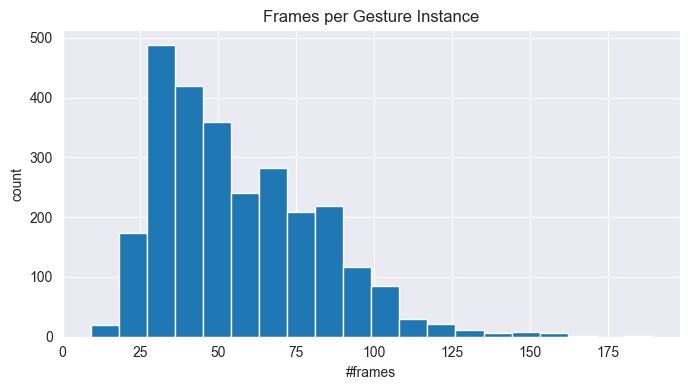

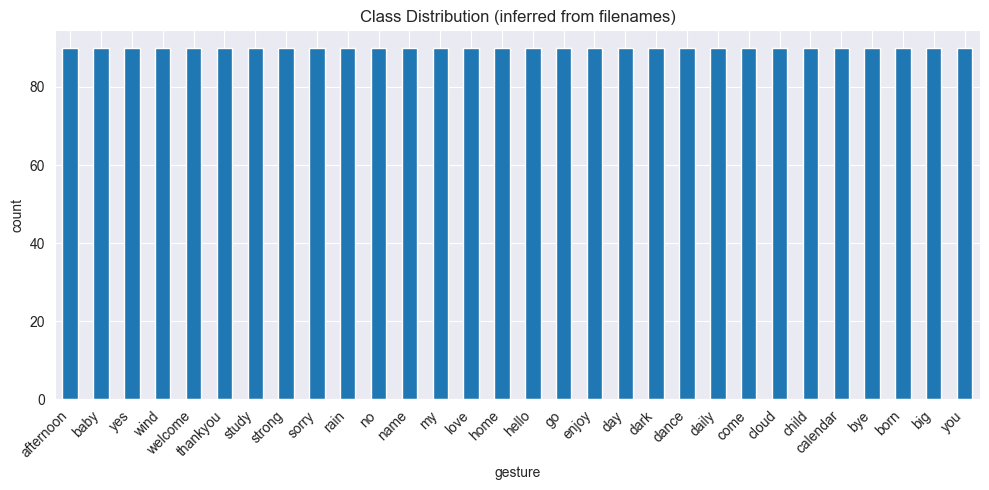

In [8]:
# ---------------------------
# 7) Descriptive Analysis (kept concise)
# ---------------------------
plt.figure(figsize=(7,4))
df["n_frames"].plot(kind="hist", bins=20)
plt.title("Frames per Gesture Instance")
plt.xlabel("#frames")
plt.ylabel("count")
plt.tight_layout()
plt.show()

if "label_name" in df.columns and df["label_name"].notna().any():
    plt.figure(figsize=(10,5))
    df["label_name"].value_counts().plot(kind="bar")
    plt.title("Class Distribution (inferred from filenames)")
    plt.xlabel("gesture")
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [9]:
# ---------------------------
# 8) Printed Descriptives
# ---------------------------
print("\n===== Descriptive Stats (Scaled Features) =====")
print(pd.DataFrame(X_scaled, columns=feature_cols).describe().round(3))

print("\nTop 10 candidates (from filenames):")
print(pd.Series(df["candidate"]).value_counts().head(10))

print("\nFrame size counts (60 vs 120):")
print(df["frame_size"].value_counts())

print("\nDone with Task 1. Proceeding to Task 2 (LSTM)...\n")



===== Descriptive Stats (Scaled Features) =====
       pos_mean_1  pos_mean_2  pos_mean_3  pos_mean_4  pos_mean_5  pos_mean_6  \
count    2700.000    2700.000    2700.000    2700.000    2700.000    2700.000   
mean        0.000       0.000       0.000       0.000       0.000      -0.000   
std         1.000       1.000       1.000       1.000       1.000       1.000   
min        -2.873      -5.767      -4.346      -2.778      -6.544      -3.806   
25%        -0.755      -0.519      -0.546      -0.710      -0.544      -0.553   
50%         0.098       0.020       0.134       0.108       0.020       0.112   
75%         0.738       0.516       0.697       0.749       0.526       0.683   
max         5.293       2.859       2.857       5.181       2.859       2.976   

       pos_mean_7  pos_mean_8  pos_mean_9  pos_mean_10  ...  ang_std_51  \
count    2700.000    2700.000    2700.000     2700.000  ...    2700.000   
mean        0.000      -0.000       0.000        0.000  ...      -0.000

In [12]:
from keras.src.callbacks import EarlyStopping
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential
from keras.src.utils import to_categorical

# ============================================================
# TASK 2: LSTM CLASSIFIER
# ============================================================
# We use train-final.csv/test-final.csv if present; otherwise use processed.csv split
# ============================================================

TRAIN_CSV = ROOT / "processed_train.csv"
TEST_CSV  = ROOT / "processed_test.csv"

if TRAIN_CSV.exists() and TEST_CSV.exists():
    print("Loading train-final.csv and test-final.csv...")
    train_df = pd.read_csv(TRAIN_CSV)
    test_df  = pd.read_csv(TEST_CSV)
else:
    print("train-final/test-final not found, using processed.csv to create split for Task 2...")
    full = pd.read_csv(full_path)
    # prefer label_name, fallback to label_id
    if "label_name" in full.columns and full["label_name"].notna().sum() > 0:
        label_col = "label_name"
    elif "label_id" in full.columns and full["label_id"].notna().sum() > 0:
        label_col = "label_id"
    else:
        raise RuntimeError("No labels found in processed.csv to train on.")

    mask = full[label_col].notna()
    df_labeled = full.loc[mask].reset_index(drop=True)

    # feature columns detection (pos/ang naming) or fallback to f1..fN
    feat_cols = [c for c in df_labeled.columns if c.startswith(("pos_mean_", "pos_std_", "ang_mean_", "ang_std_"))]
    if len(feat_cols) == 0:
        feat_cols = [c for c in df_labeled.columns if c.startswith("f") and c[1:].isdigit()]
    if len(feat_cols) == 0:
        raise RuntimeError("No recognizable feature columns in processed.csv")

    X_all = df_labeled[feat_cols]
    y_all = df_labeled[label_col].astype(str)  # cast to str to ensure LabelEncoder works consistently

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )

    train_df = pd.concat([X_train.reset_index(drop=True), df_labeled.loc[X_train.index, df_labeled.columns.difference(feat_cols)].reset_index(drop=True)], axis=1)
    test_df  = pd.concat([X_test.reset_index(drop=True),  df_labeled.loc[X_test.index,  df_labeled.columns.difference(feat_cols)].reset_index(drop=True)], axis=1)

# At this point train_df/test_df should contain feature columns and either label_name or label_id
# Detect feature columns
feature_columns = [c for c in train_df.columns if c.startswith(("pos_mean_", "pos_std_", "ang_mean_", "ang_std_"))]
if len(feature_columns) == 0:
    # fallback to f1...fN
    feature_columns = [c for c in train_df.columns if c.startswith("f") and c[1:].isdigit()]
if len(feature_columns) == 0:
    raise RuntimeError("Could not detect feature columns in train-final/test-final.")

print(f"Detected {len(feature_columns)} feature columns for modelling.")

# Prepare labels: prefer label_name then label_id
if "label_name" in train_df.columns and train_df["label_name"].notna().any():
    raw_y_train = train_df["label_name"].astype(str)
    raw_y_test  = test_df["label_name"].astype(str)
elif "label_id" in train_df.columns and train_df["label_id"].notna().any():
    raw_y_train = train_df["label_id"].astype(str)
    raw_y_test  = test_df["label_id"].astype(str)
else:
    raise RuntimeError("No usable labels in train/test for Task 2.")

# Drop any rows with missing labels in train/test (report counts)
train_na_before = len(raw_y_train) - raw_y_train.notna().sum()
test_na_before  = len(raw_y_test)  - raw_y_test.notna().sum()
if train_na_before > 0 or test_na_before > 0:
    print(f"Dropping {train_na_before} rows from train and {test_na_before} rows from test due to missing labels.")

# Filter corresponding feature rows
train_mask = raw_y_train.notna()
test_mask  = raw_y_test.notna()

train_df_clean = train_df.loc[train_mask].reset_index(drop=True)
test_df_clean  = test_df.loc[test_mask].reset_index(drop=True)

X_train = train_df_clean[feature_columns].values
X_test  = test_df_clean[feature_columns].values
y_train_raw = (train_df_clean["label_name"].astype(str) if "label_name" in train_df_clean.columns else train_df_clean["label_id"].astype(str))
y_test_raw  = (test_df_clean["label_name"].astype(str)  if "label_name" in test_df_clean.columns else  test_df_clean["label_id"].astype(str))

# Encode labels to contiguous integers 0..K-1
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_raw)
y_test_enc  = le.transform(y_test_raw)  # assumes labels in test are seen in train (if not, will error)

num_classes = len(le.classes_)
print(f"Label encoder found {num_classes} classes. Classes: {list(le.classes_)}")

# One-hot
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# Reshape features for LSTM:
# treat each sample as sequence length = number of raw feature columns, features_per_timestep = 1
seq_len = X_train.shape[1]
X_train_seq = X_train.reshape((X_train.shape[0], seq_len, 1))
X_test_seq  = X_test.reshape((X_test.shape[0], seq_len, 1))
print("Reshaped inputs for LSTM:", X_train_seq.shape, X_test_seq.shape)

# Build LSTM model
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(128, input_shape=(seq_len, 1), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# Training
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
history = model.fit(
    X_train_seq, y_train_cat,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# Save model artifact
MODEL_DIR = ROOT / "artifacts"
MODEL_DIR.mkdir(exist_ok=True)
model.save(MODEL_DIR / "lstm_model.keras")
print(f"Saved trained LSTM model to {MODEL_DIR / 'lstm_model.keras'}")

Loading train-final.csv and test-final.csv...
Detected 240 feature columns for modelling.
Label encoder found 31 classes. Classes: ['afternoon', 'baby', 'big', 'born', 'bye', 'calendar', 'child', 'cloud', 'come', 'daily', 'dance', 'dark', 'day', 'enjoy', 'go', 'hello', 'home', 'label_name', 'love', 'my', 'name', 'no', 'rain', 'sorry', 'strong', 'study', 'thankyou', 'welcome', 'wind', 'yes', 'you']
Reshaped inputs for LSTM: (2161, 240, 1) (541, 240, 1)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,831 (300.12 KB)

 Trainable params: 76,831 (300.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
58/58 - 6s - 104ms/step - accuracy: 0.0349 - loss: 3.4213 - val_accuracy: 0.0338 - val_loss: 3.4206
Epoch 2/100
58/58 - 6s - 95ms/step - accuracy: 0.0463 - loss: 3.3990 - val_accuracy: 0.0277 - val_loss: 3.4294
Epoch 3/100
58/58 - 5s - 85ms/step - accuracy: 0.0485 - loss: 3.3819 - val_accuracy: 0.0400 - val_loss: 3.3728
Epoch 4/100
58/58 - 5s - 86ms/step - accuracy: 0.0605 - loss: 3.3150 - val_accuracy: 0.0462 - val_loss: 3.3058
Epoch 5/100
58/58 - 5s - 84ms/step - accuracy: 0.0545 - loss: 3.3074 - val_accuracy: 0.0400 - val_loss: 3.3363
Epoch 6/100
58/58 - 5s - 86ms/step - accuracy: 0.0566 - loss: 3.2923 - val_accuracy: 0.0492 - val_loss: 3.3190
Epoch 7/100
58/58 - 5s - 85ms/step - accuracy: 0.0643 - loss: 3.2481 - val_accuracy: 0.0492 - val_loss: 3.2568
Epoch 8/100
58/58 - 5s - 84ms/step - accuracy: 0.0703 - loss: 3.2419 - val_accuracy: 0.0338 - val_loss: 3.3040
Epoch 9/100
58/58 - 5s - 85ms/step - accuracy: 0.0632 - loss: 3.2322 - val_accuracy: 0.0523 - val_loss: 3.2385


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

✅ Test Accuracy: 0.0610

Classification Report:
              precision    recall  f1-score   support

   afternoon       0.00      0.00      0.00        18
        baby       0.03      0.11      0.04        18
         big       0.00      0.00      0.00        18
        born       0.00      0.00      0.00        18
         bye       0.00      0.00      0.00        18
    calendar       0.00      0.00      0.00        18
       child       0.00      0.00      0.00        18
       cloud       0.00      0.00      0.00        18
        come       0.00      0.00      0.00        18
       daily       0.00      0.00      0.00        18
       dance       0.00      0.00      0.00        18
        dark       0.19      0.17      0.18        18
         day       0.00      0.00      0.00        18
       enjoy       0.00      0.00      0.00        18
          go       0.00      0.00      0.00        18
       hello       0.00      0.00      0.00   

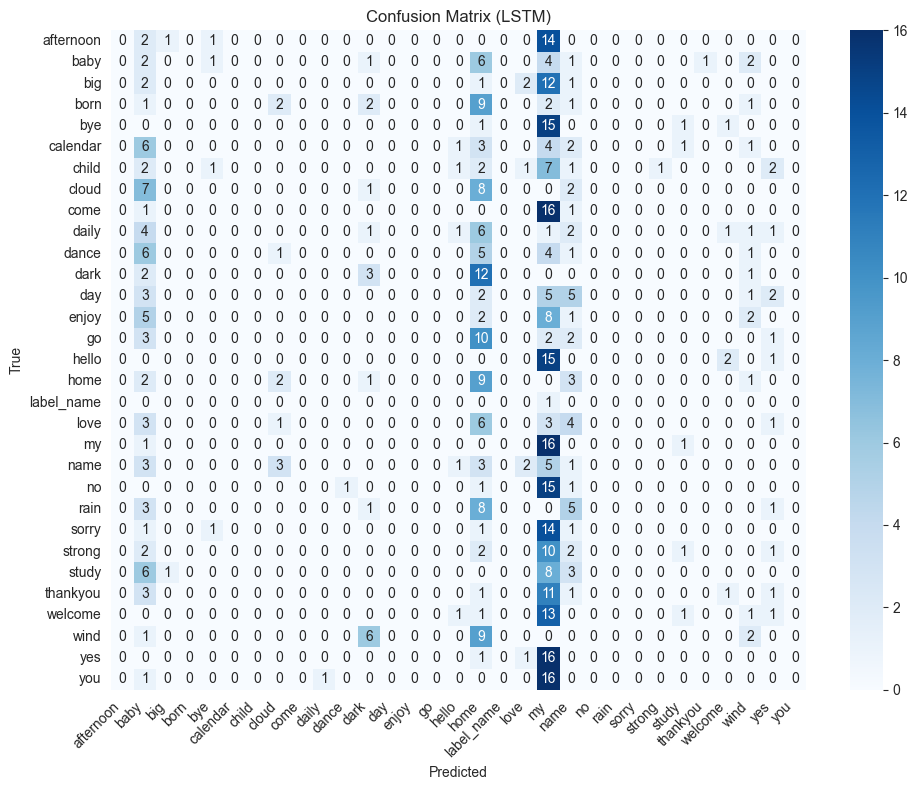

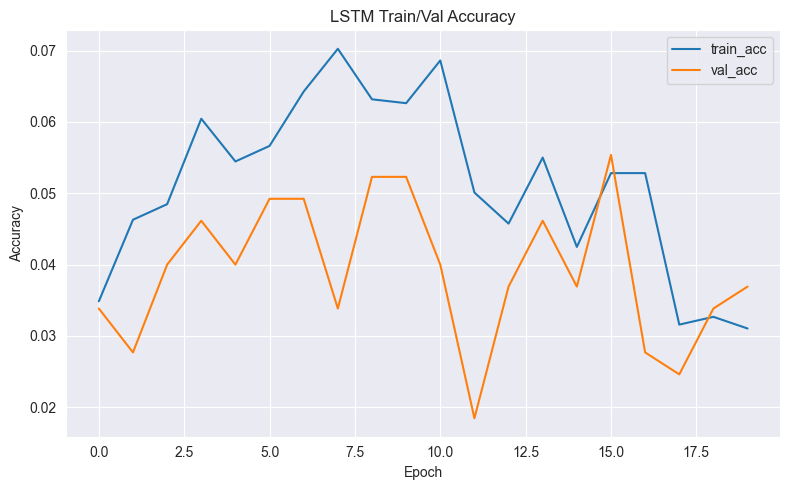

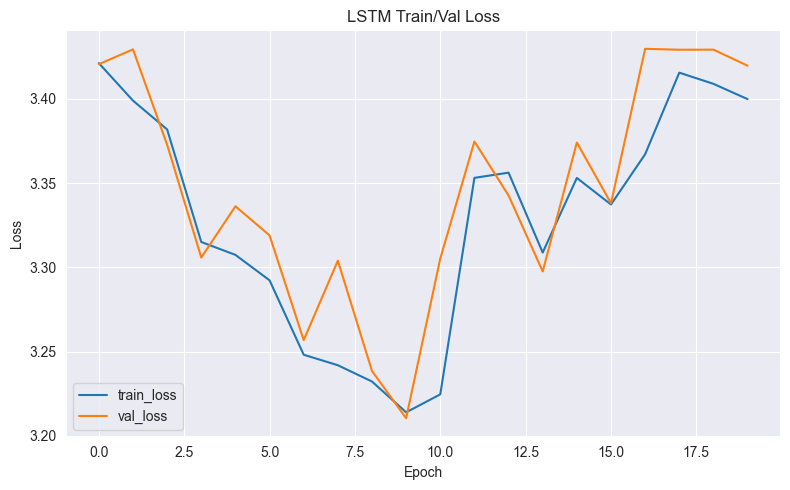

In [13]:
# ---------- Evaluate ----------
y_pred_prob = model.predict(X_test_seq)
y_pred_enc = np.argmax(y_pred_prob, axis=1)
y_pred = le.inverse_transform(y_pred_enc)  # original labels (strings or numeric-as-str)

# For evaluation, ensure y_test_raw is aligned type (string)
y_test_vals = y_test_raw.values.astype(str)

acc = accuracy_score(y_test_vals, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test_vals, y_pred, zero_division=0))

# Confusion matrix (display with label names)
cm = confusion_matrix(y_test_vals, y_pred, labels=le.classes_)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix (LSTM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Training curves
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("LSTM Train/Val Accuracy")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Train/Val Loss")
plt.tight_layout()
plt.show()